In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# import the MNIST dataset
import torchvision.datasets as datasets
from torchvision import transforms

import torchsummary

from sklearn.model_selection import train_test_split

# from torchdiffeq import odeint, odeint_adjoint

import cv2
import numpy as np

from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [4]:
class Ball:
    def __init__(self, x0, r, move_func):
        self.x0 = x0
        self.r = int(np.array(r))
        self.x = np.copy(x0)
        self.t = 0
        self.move_func = move_func

    def reset(self):
        self.x = np.copy(self.x0)
        self.t = 0

    def step(self, dt):
        self.t += dt
        x = np.copy(self.x)
        self.x += dt*self.move_func(self.t, x)
        
        return self.x

    

class Image(Ball):
    def __init__(self, x0, r, move_func, size, border=2):
        super(Image, self).__init__(x0, r, move_func)
        self.size = size
        self.border = border
        self.image_dim = (size, size, 3)
        self.image = np.zeros(self.image_dim, dtype=np.uint8)
        
        x = self.compute_position_on_image(self.x)
        self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def compute_position_on_image(self, x):
        x = (x - self.border[0])/(self.border[1] - self.border[0])
        x = x*(self.size-1)
        x = x.astype(np.uint8)
        x = np.clip(x, 0, self.size-1)

        return x

    def update_image(self):
        x = self.compute_position_on_image(self.x)
        self.image = cv2.circle(np.zeros(self.image_dim, dtype=np.uint8), (x[0], x[1]), self.r, (255, 255, 255), -1)


    def display(self):
        self.update_image()
        plt.imshow(self.image)
        plt.show()

    def forward(self, dt):
        x = self.step(dt)
        self.update_image()
        return x

    def animate(self, dt, frames=100, interval=20, repeat_delay=0):
        
        self.reset()
        fig = plt.figure()
        ax = plt.axes(xlim=(0, self.size), ylim=(0, self.size))
        ax.imshow(self.image)

        def init():
            self.reset()
            ax.imshow(self.image)
            return ax,

        def update(i):
            self.forward(dt)
            ax.imshow(self.image)
            return ax,
            

        anim = FuncAnimation(fig, update, init_func=init, frames=trange(0,frames), interval=interval, repeat_delay=repeat_delay)
        # plt.show()
        anim.save('images/ODE/ball_animation.gif', writer='pillow')
        plt.close()

    def generate_samples(self, dt, frames=100, conv=False):
        self.reset()


        if frames > 0:
            if conv:
                samples = np.zeros((frames, 1, self.image_dim[0], self.image_dim[1]))

            else:
                samples = np.zeros((frames, self.image_dim[0], self.image_dim[1]))

            for i in range(frames):
                self.forward(dt)
                if conv:
                    samples[i, 0] = self.image[:,:,0]

                else:
                    samples[i] = self.image[:,:,0]

            return samples

        else:
            samples = []
            current_x = np.copy(self.x)
            while True:
                x = self.forward(dt)
                if np.linalg.norm(x - current_x) < 1E-2*dt:
                    break
                current_x = np.copy(x)
                if conv: 
                    samples.append(np.expand_dims(self.image[:,:,0], axis=0))
                else:
                    samples.append(self.image[:,:,0])
                
            return np.array(samples)


def move_fun_circle(t, x, w=1, exp_decay=1.):
    return np.exp(-exp_decay*t)*np.array([-w*np.sin(w*t), w*np.cos(w*t)], dtype=np.float32)    


In [5]:
def create_random_dataset(r_max, n_samples, size, conv=False):
    data = []
    for i in range(n_samples):
        r = np.random.randint(r_max)
        image = np.zeros((size, size), dtype=np.uint8)
        x = np.random.randint(low=1, high=size, size=(2))
        image = cv2.circle(image, (x[0], x[1]), r, 255, -1)/255.
        if conv:
            image = np.expand_dims(image, axis=0)
        data.append([image, np.array([x[0]/size, x[1]/size, r/r_max]) ] )

    return data

# samples = create_random_dataset(10, 120000, 128)
def gaussian_density(x, mu, sigma):
    return torch.exp(-torch.norm(torch.tensor(x - mu).float(), dim=1)**2/(2*sigma**2))/(2*np.pi*sigma**2)

def create_gaussian_dataset(r_min, r_max, n_samples, size):
    samples = np.zeros((n_samples, 1, size, size))
    indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    # print(indices_matrix)
    # print(indices_matrix.shape)
    eps = 1E-5
    for i in range(n_samples):
        r = np.random.uniform(r_min, r_max+eps)
        # create a gaussian ball
        image = np.zeros((size, size), dtype=np.uint8)
        x = np.random.randint(size, size=(2))
        # compute the density over the image and normalize it
        image = gaussian_density(indices_matrix, x, r).numpy().copy()
        samples[i, 0] = image.reshape(size, size)
        
    return samples

samples = create_gaussian_dataset(1., 1., 8000, 28)

In [6]:
class custom_loss(nn.Module):
    def __init__(self, image_loss=nn.BCELoss(), factor=0.5, normalize=False):
        super(custom_loss, self).__init__()
        self.image_loss = image_loss
        self.factor = factor
        self.normalize = normalize
        self.latent_loss = nn.MSELoss()

    def forward(self, true_image, image, true_position, position):
        # print((1-self.factor)*self.image_loss(true_image, image))
        # print(self.factor*torch.mean(torch.sum((true_position - position)**2, dim=1)))
        loss = (1-self.factor)*self.image_loss(true_image, image)*100
        if self.normalize:
            loss = loss/torch.mean(torch.sum(true_image, dim=(1,2)))

        # print(loss, self.factor*torch.mean(torch.sum((true_position - position)**2, dim=(1))))

        loss += self.factor*self.latent_loss(true_position, position)
        
        # if self.normalize:
        #     loss += 10E-5*torch.mean(torch.sum((position)**2, dim=1))

        return loss

loss_fn = custom_loss(nn.MSELoss(), 0.5, normalize=False)

In [7]:
def train(model, dataloader_train, dataloader_test, optimizer, scheduler, criterion, epochs=10, display_step=1):
    
    iterator = trange(epochs)
    losses_train = []
    losses_test = []
    for _ in iterator:
        loss_epoch = 0
        model.train()
        for i, data in enumerate(dataloader_train):
            image, position = data
            image = image.float()
            position = position.float()
            optimizer.zero_grad()
            output, position_pred = model(image)
            loss = criterion(image.squeeze(), output.squeeze(), position, position_pred)
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            if i % display_step == 0:
                iterator.set_description(f'Batch: {i}/{len(dataloader_train)}, Loss: {loss_epoch/(i+1):.6f}')
            

        losses_train.append(loss_epoch/len(dataloader_train))
        model.eval()
        with torch.no_grad():
            loss_epoch = 0
            for i, data in enumerate(dataloader_test):
                image, position = data
                image = image.float()
                position = position.float()    
                output, position_pred = model(image)
                loss = criterion(image.squeeze(), output.squeeze(), position, position_pred)
                loss_epoch += loss.item()
                if i % display_step == 0:
                    iterator.set_postfix_str(f'Test Batch: {i}/{len(dataloader_test)}, Loss: {loss_epoch/(i+1):.6f}')
            
            losses_test.append(loss_epoch/len(dataloader_test))
            
        scheduler.step()
        
    return losses_train, losses_test

In [8]:
# Split train and test data using sklearn
samples_train, samples_test= train_test_split(samples, test_size=0.3, random_state=42)
# create a dataloader from the matrix of samples

dataloader_train = DataLoader(samples_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(samples_test, batch_size=64, shuffle=False)

# MLP

In [105]:
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Linear(in_features=self.height*self.width, out_features=32),
                    nn.ReLU(),
                    nn.Linear(in_features=32, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=32),
                    nn.ReLU(),
                    nn.Linear(in_features=32, out_features=self.height*self.width),
                    nn.Sigmoid()
        )

        print("Parameters number: ", sum([p.numel() for p in self.parameters()]))
        

    def forward(self, features):
        out = self.flatten(features)
        positions = self.encoder(out)
        out = self.decoder(positions)
        reconstructed = out.view(features.shape[0], self.height, self.width)
        return reconstructed, positions

In [194]:
model = AE(height=128, width=128, latent_dim=3)

Parameters number:  1065219


In [197]:
loss_fn = custom_loss(nn.MSELoss(), 0.4)
optimizer = optim.Adam(model.parameters(), lr=0.01)
losses_train, losses_test = train(model, dataloader_train, dataloader_test,
                            optimizer, loss_fn, epochs=150, display_step=2)

  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [129]:
torch.save(model.state_dict(), 'models/AE/custom_MLP_3_dim_good_res.pt')

Position predicted : [0.24350426 0.80103207] | True position : [0.75     0.921875]


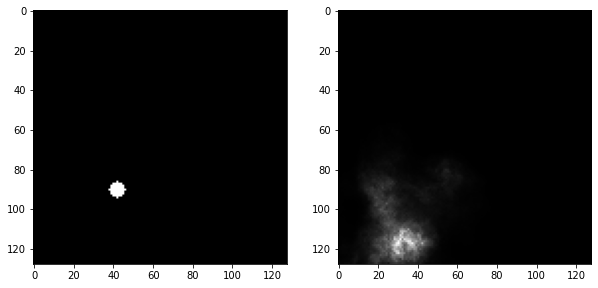

Position predicted : [0.         0.37604773] | True position : [0.9140625 0.125    ]


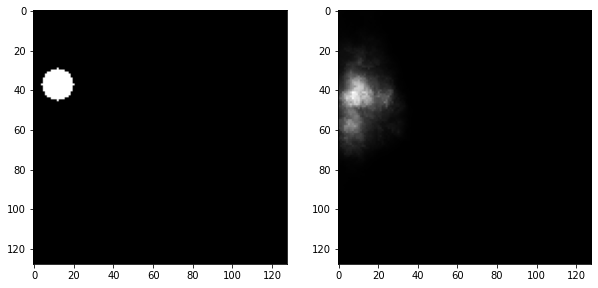

Position predicted : [0.25297895 0.44719443] | True position : [0.890625 0.234375]


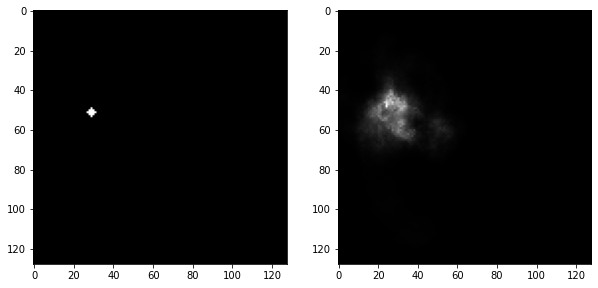

Position predicted : [0.         0.22704288] | True position : [0.53125   0.4921875]


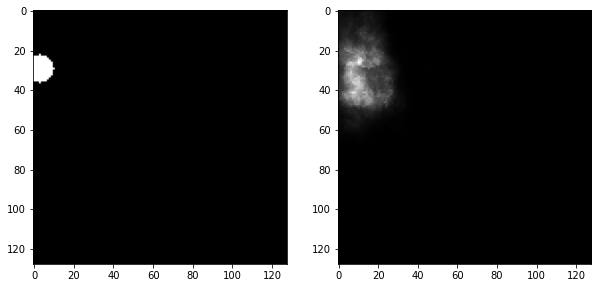

Position predicted : [0.35932225 0.57641655] | True position : [0.09375   0.8203125]


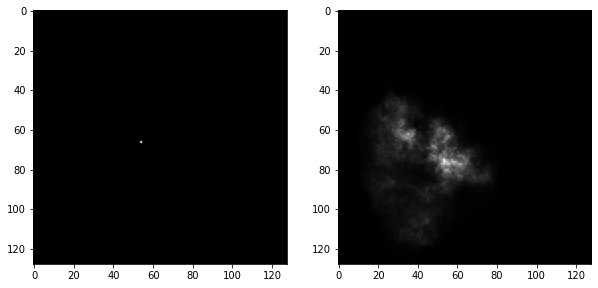

Position predicted : [0.       1.092314] | True position : [0.890625  0.2109375]


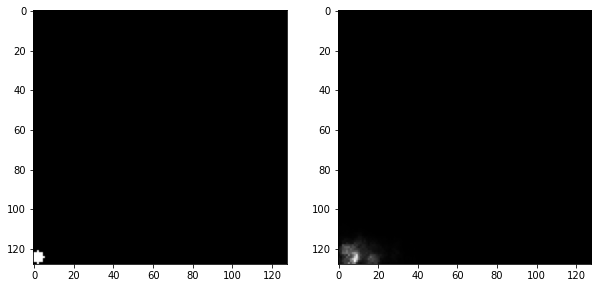

In [198]:
images = [image for image, _ in samples_train]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image, pred_position = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    pred_position = pred_position.detach().numpy()

    print(f"Position predicted : {pred_position[0,:2]} | True position : {samples[index][1][:2]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()

# Trying CNN AE for 128 images

## Huge model

In [9]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=1024, out_features=256),
                    nn.ReLU(),
                    nn.Linear(in_features=256, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=256),
                    nn.ReLU(),
                    nn.Linear(in_features=256, out_features=1024),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        out = self.encoder(image)
        positions = self.encoder_linear(out)
        out = self.decoder_linear(positions)
        out = out.view(image.shape[0], 1024, 1, 1)
        out = self.decoder(out)
        return out, positions

    def encode(self, image):
        out = self.encoder(image)
        return out

    def decode(self, latent_vector):
        out = self.decoder(latent_vector)
        return out
        

## Smaller model

In [44]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=32, out_channels=48, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=48, out_channels=72, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=72, out_channels=108, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=108, out_channels=162, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=162, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=self.latent_dim),
                    nn.ReLU()
        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=64),
                    nn.ReLU(),
                    nn.Linear(in_features=64, out_features=162),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=162, out_channels=108, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=108, out_channels=72, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=72, out_channels=48, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=48, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        out = self.encoder(image)
        positions = self.encoder_linear(out)
        out = self.decoder_linear(positions)
        out = out.view(image.shape[0], 162, 1, 1)
        out = self.decoder(out)
        return out, positions

    def encode(self, image):
        out = self.encoder(image)
        return out

    def decode(self, latent_vector):
        out = self.decoder(latent_vector)
        return out
        

In [53]:
model = ConvAE(height=64, width=64, latent_dim=30)
torchsummary.summary(model, (1, 64, 64))

Number of parameters in the model: 799251
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 31, 31]             416
              ReLU-2           [-1, 16, 31, 31]               0
            Conv2d-3           [-1, 32, 15, 15]           8,224
              ReLU-4           [-1, 32, 15, 15]               0
            Conv2d-5             [-1, 48, 8, 8]          13,872
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 72, 4, 4]          31,176
              ReLU-8             [-1, 72, 4, 4]               0
            Conv2d-9            [-1, 108, 2, 2]          70,092
             ReLU-10            [-1, 108, 2, 2]               0
           Conv2d-11            [-1, 162, 1, 1]         157,626
             ReLU-12            [-1, 162, 1, 1]               0
          Flatten-13                  [-1, 162]              

## 28x28 CNN Model

In [10]:
class ConvAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.flatten = nn.Flatten()
        self.height = kwargs['height']
        self.width = kwargs['width']
        self.latent_dim = kwargs['latent_dim']

        self.encoder = nn.Sequential(
                    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    # nn.MaxPool2d(kernel_size=2, stride=2),
                    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
                    nn.ReLU()
                    # nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        self.encoder_linear = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=3*3*128, out_features=self.latent_dim),
                    nn.ReLU(),

        )

        self.decoder_linear = nn.Sequential(
                    nn.Linear(in_features=self.latent_dim, out_features=3*3*128),
                    nn.ReLU()
        )
        self.decoder = nn.Sequential(
                    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
                    nn.ReLU(),
                    nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=4, stride=2, padding=1),
                    nn.Sigmoid()
        )

        # print the number of parameters in the model
        print("Number of parameters in the model: {}".format(np.sum([p.numel() for p in self.parameters() if p.requires_grad])))

    def forward(self, image):
        out = self.encoder(image)
        reconstructed = self.encoder_linear(out)
        out = self.decoder_linear(reconstructed)
        out = out.view(image.shape[0], 128, 3, 3)
        out = self.decoder(out)
        return out, reconstructed

    def encode(self, image):
        out = self.encoder(image)
        return out

    def decode(self, latent_vector):
        out = self.decoder(latent_vector)
        return out

In [11]:
model = ConvAE(height=28, width=28, latent_dim=2)
torchsummary.summary(model, (1, 28, 28))
model.load_state_dict(torch.load("models/AE/conv_custom_2_custom_loss_alpha_0_3.pt"))

Number of parameters in the model: 220387
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 13, 13]             832
              ReLU-2           [-1, 32, 13, 13]               0
            Conv2d-3             [-1, 64, 6, 6]          32,832
              ReLU-4             [-1, 64, 6, 6]               0
            Conv2d-5            [-1, 128, 3, 3]          73,856
              ReLU-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                    [-1, 2]           2,306
              ReLU-9                    [-1, 2]               0
           Linear-10                 [-1, 1152]           3,456
             ReLU-11                 [-1, 1152]               0
  ConvTranspose2d-12             [-1, 64, 7, 7]          73,792
             ReLU-13             [-1, 64, 7, 7]              

<All keys matched successfully>

## Training

In [12]:
# def create_random_dataset(r_max, n_samples, size, conv=False):
#     data = []
#     for i in range(n_samples):
#         r = np.random.randint(r_max)
#         image = np.zeros((size, size), dtype=np.uint8)
#         x = np.random.randint(low=1, high=size, size=(2))
#         image = cv2.circle(image, (x[0], x[1]), r, 255, -1)/255.
#         if conv:
#             image = np.expand_dims(image, axis=0)
#         data.append([image, np.array([x[0]/size, x[1]/size, r/r_max]) ] )

#     return data

# samples = create_random_dataset(13, 30000, 64, conv=True)

def gaussian_density(x, mu, sigma):
    return torch.exp(-torch.norm(torch.tensor(x - mu).float(), dim=1)**2/(2*sigma**2))/(2*np.pi*sigma**2)

def create_gaussian_dataset(r_min, r_max, n_samples, size, margin=1.):
    samples = []
    indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    # print(indices_matrix)
    # print(indices_matrix.shape)
    eps = 1E-5

    for i in range(n_samples):
        sigma = np.random.uniform(r_min, r_max+eps)
        # create a gaussian ball
        image = np.zeros((size, size), dtype=np.float32)
        mu = np.random.uniform(low=margin, high=size - 1 - margin, size=(2))
        # mu = np.random.randint(size, size=(2))
        # compute the density over the image and normalize it
        image = gaussian_density(indices_matrix, mu, sigma).numpy().copy()
        samples.append([image.reshape(1, size, size), np.array([mu[0]/(size ), mu[1]/(size)])])
        
    return samples


samples = create_gaussian_dataset(1., 1., 5000, 28, margin=2.)

In [197]:
# Split train and test data using sklearn
samples_train, samples_test= train_test_split(samples, test_size=0.7, random_state=42)
# create a dataloader from the matrix of samples

dataloader_train = DataLoader(samples_train, batch_size=32, shuffle=True)
dataloader_test = DataLoader(samples_test, batch_size=32, shuffle=False)

In [198]:
# model.load_state_dict(torch.load('models/AE/conv_custom_3_custom_loss.pt'))
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

In [202]:
loss_fn = custom_loss(nn.MSELoss(), factor=1., normalize=True)
losses_train, losses_test = train(model, dataloader_train, dataloader_test,
                            optimizer, scheduler, loss_fn, epochs=300, display_step=2)

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [204]:
torch.save(model.state_dict(), 'models/AE/conv_custom_2_gaussian_r_1_custom_loss_alpha_1_0.pt')

Position predicted : [0.7647642  0.08716013] | True position : [0.47954382 0.08676814]


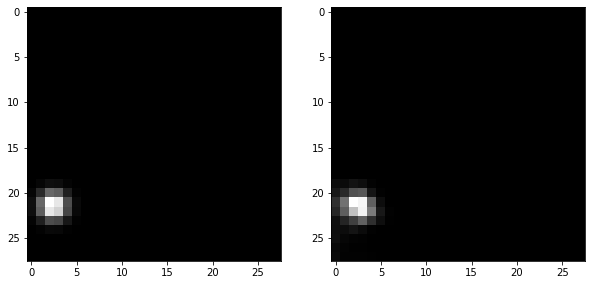

Position predicted : [0.09018932 0.48201206] | True position : [0.0805721  0.52112396]


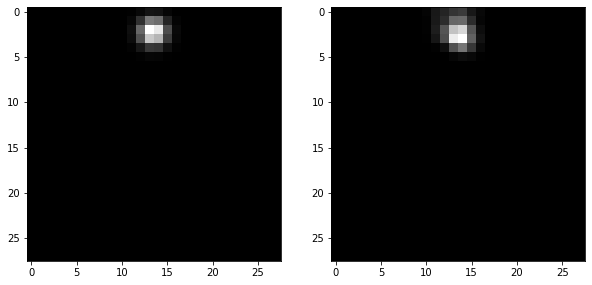

Position predicted : [0.5522525  0.50126064] | True position : [0.18726104 0.17631683]


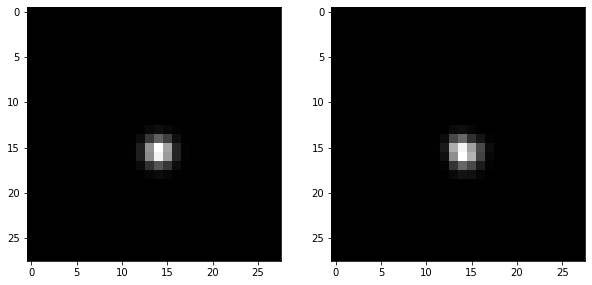

Position predicted : [0.25768942 0.24331652] | True position : [0.74594294 0.84306782]


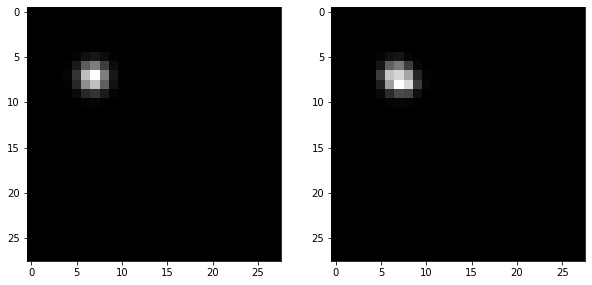

Position predicted : [0.6186066 0.344607 ] | True position : [0.50208385 0.87841343]


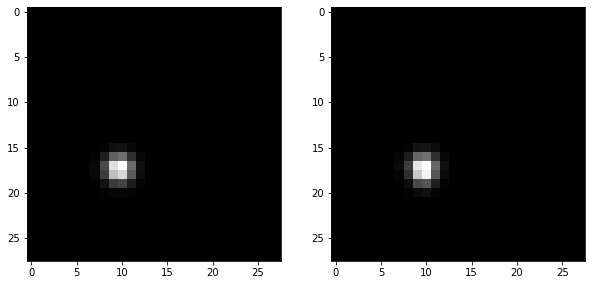

Position predicted : [0.7202496 0.627574 ] | True position : [0.68889697 0.6855767 ]


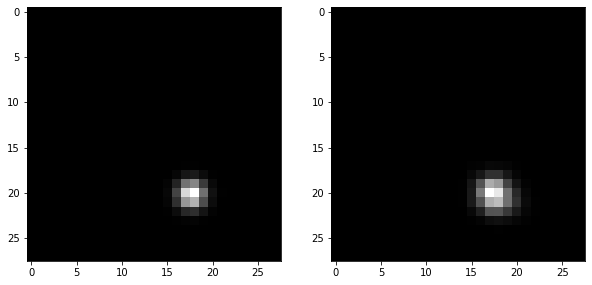

In [203]:
images = [image for image, _ in samples_test]
for i, index in enumerate([0, len(images)//5, len(images)//4, len(images)//2, 3*len(images)//4, -1]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    pred_image, pred_position = model(torch.tensor(images[index]).float().unsqueeze(0))
    pred_image = pred_image.detach().numpy()
    pred_position = pred_position.detach().numpy()

    print(f"Position predicted : {pred_position[0,:]} | True position : {samples[index][1][:]}")
    # print(f"Radius predicted : {pred_position[0,2]} | Radius position : {samples[index][1][2]}")
    ax[0].imshow(np.squeeze(images[index]), cmap='gray')
    ax[1].imshow(pred_image.squeeze(), cmap='gray')
    plt.show()

# Visualizing the latent transformation

In [117]:
def grid_samples(k, size, r_min, r_max, margin=1.):
    samples = []
    indices_matrix = np.array([[i,j] for i in range(size) for j in range(size)])
    # print(indices_matrix)
    # print(indices_matrix.shape)
    eps = 1E-5
    step = (size - 2.*margin)/k
    positions_x = np.arange(margin, size - 1 - margin, step)
    positions_y = np.arange(margin, size - 1 - margin, step)
    for x in positions_x:
        for y in positions_y:
            r = np.random.uniform(r_min, r_max+eps)
            # create a gaussian ball
            image = np.zeros((size, size), dtype=np.float32)
            position = np.array([x, y])
            
            # compute the density over the image and normalize it
            image = gaussian_density(indices_matrix, position, r).numpy().copy()
            samples.append((image.reshape(1, size, size), np.array([x/(size ), y/(size)])))
        
    return samples

grid = grid_samples(16, 28, 1., 1., margin=1)

In [118]:
def plot_grid(ax, positions):
    # print(positions)
    plt.figure(figsize=(8, 8))
    # add line to the grid
    dim_positions = positions.shape[0]
    dim_positions = int(np.sqrt(dim_positions))
    # print(dim_positions)
    # print(positions.shape)
    try_pos = positions.reshape(dim_positions,dim_positions,2)
    ax.plot(try_pos[:,:,0], try_pos[:,:,1], 'k-', linewidth=0.5)
    ax.plot(try_pos[:,:,1], try_pos[:,:,0], 'k-', linewidth=0.5)
    ax.scatter(positions[:,0], positions[:,1], s=6)
    # plt.show()

# plot_grid(grid)

In [119]:
def plot_square_transformation(model, square_samples, title):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    with torch.no_grad():
        pred_positions = np.array([model.encoder_linear(model.encode(torch.tensor(image).float().unsqueeze(0))).numpy()[0] for image, _ in square_samples])
        # print(pred_position.shape)
        # add overall title
        ax[0].set_title("Inputs")
        ax[1].set_title(title)
        true_positions = np.array([position for _, position in square_samples])
        # print(true_positions.shape)
        # print(pred_positions.shape)
        # print(true_positions)
        plot_grid(ax[0], true_positions)
        plot_grid(ax[1], pred_positions)
        # ax[0].scatter(true_positions[:,0], true_positions[:,1], s=1, label="True position of the center")
        # ax[1].scatter(pred_position[:,0], pred_position[:,1], s=1, label="Predicted position of the center")
        # ax[0].legend()
        # ax[1].legend()
        plt.show()

In [125]:
model = ConvAE(height=28, width=28, latent_dim=2)
model.load_state_dict(torch.load("models/AE/conv_custom_2_gaussian_r_1_custom_loss_alpha_1_0.pt"))

Number of parameters in the model: 220387


<All keys matched successfully>

(256, 2)
(256, 2)
16
(256, 2)
16
(256, 2)


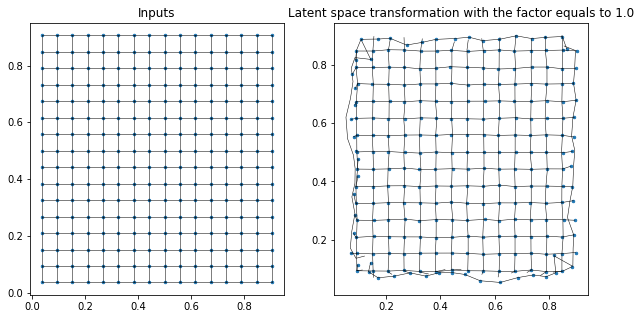

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

In [126]:
title = "Latent space transformation with the factor equals to 1.0"
plot_square_transformation(model, grid, title)